# MultiCamera Paper Results Generation and Plotting

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [4]:
import sys
sys.path.append("../..") # Adds higher directory to python modules path.

from utilitysimv4 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [5]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/new_profiling/cityscapes/meta/profiles'
INFERENCE_PROFILE_PATH = '../real_inference_profiles.csv'
INFERENCE_MAX_DEFAULT = 0.25

In [6]:
def read_profiles(profile_dir, city_name, use_oracle = False):
    # use_oracle: Use oracle data instead of predictions
    profile_path = os.path.join(profile_dir, "{}.json".format(city_name))
    with open(profile_path) as f:
        data = json.load(f)
    offset = int(sorted(data["taskwise_train_profiles"], key=lambda x: int(x))[0])
    final_data = {"taskwise_train_profiles": {},
                  "taskwise_infer_profiles": {},
                  "taskwise_predicted_profiles": {}}
    for key in data["taskwise_train_profiles"].keys():
        final_data["taskwise_train_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
    for key in data["taskwise_infer_profiles"].keys():
        final_data["taskwise_infer_profiles"][str(int(key)-offset)] = data["taskwise_infer_profiles"][key]
    for key in data["taskwise_predicted_profiles"].keys():
        if use_oracle:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
        else:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_predicted_profiles"][key]
    assert "taskwise_train_profiles" in final_data
    assert "taskwise_infer_profiles" in final_data
    return final_data

def create_cameras(city_names, profile_dir = PROFILE_DIR, inference_max_resources = INFERENCE_MAX_DEFAULT, use_oracle = False):
    cameras = []
    print("Creating cameras for cities {}".format(city_names))
    for idx, city in enumerate(city_names):        
        data_pred = read_profiles(profile_dir, city, use_oracle)
        
        TASKS = data_pred["taskwise_train_profiles"].keys()
        # Format = [Acc, res_time, 0]
        train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_predicted_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # Format = [Acc, res_time, 0]
        oracle_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # TODO: Picking min profile, which else can we pick?
        infer_start_accs = {TASK_ID: min([acc for hp_id, acc in data_pred["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

        cameras.append(Camera("{}_{}".format(city, idx),
                              train_profiles,
                              oracle_profiles,
                              infer_start_accs,
                              inference_profile_path=INFERENCE_PROFILE_PATH,
                              inference_max_resources=inference_max_resources
                             ))
    return cameras

# Cost vs accuracy - Multi Cam

In [7]:
def get_citywise_data(results, city):
    tasks = list(results.keys())
    tasks.remove('meta')
    final_data = None
    for task in tasks:
        for job in results[task].keys():
            if isinstance(job, InferenceJob):
                if city in job.name:
                    d = results[task][job]
                    time, acc = list(zip(*d))
                    data = pd.DataFrame(acc, columns=['task_{}'.format(task)], index=time)
                    data.index.name = 'time'
                    if final_data is None:
                        final_data = data
                    else:
                        final_data = final_data.join(data)
    return final_data

In [8]:
l=os.listdir(PROFILE_DIR)
cities=[x.split('.')[0] for x in l]
print(cities)

['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']


In [ ]:
data = []
all_data = pd.DataFrame()
#cities = ["phx-21-40", "phx-41-60"]
INFER_MAX_RES = 0.25

periods_to_test = [100,200] #[10, 50, 100, 200, 400]
provisioned_res_to_test = [1,2,4,8]#np.arange(0,1,0.2)#,2,4,8,16]#,32,64]#[1,2,4,8,16]#list(np.arange(0,1,0.05))#
task_ids = [str(x) for x in range(1,6)]
use_oracle_modes = [True, False]

allocation = defaultdict(dict)
camera_names = cities

schedulers_to_test = [(fair_dumb_scheduler, 'fair_dumb'),
                     # (fair_naive_scheduler, 'fair_naive'),
                     (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=3,steal_increment=INFER_MAX_RES/3), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

column_names = ['period', 'resources', 'use_oracle', *[sched_name for _, sched_name in schedulers_to_test]]
for retraining_period in periods_to_test:
    for provisioned_res in provisioned_res_to_test:
        for use_oracle in use_oracle_modes:
            this_config_result = [retraining_period, provisioned_res, use_oracle]
            for scheduler, sched_name in schedulers_to_test:
                print("Sched: {}, Resources: {}. Period: {}. Use_Oracle: {}.".format(
                    sched_name, provisioned_res, retraining_period, use_oracle))
                cameras = create_cameras(camera_names, inference_max_resources = INFER_MAX_RES, use_oracle=use_oracle)
                mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, task_ids = task_ids)
                results, period_allocation_log = mps.step_till_completion()
                
                #Get citywise data
                for city in cities:
                    d=get_citywise_data(results, city)
                    d['city']=city
                    d['res']=provisioned_res
                    d['period']=retraining_period
                    d['use_oracle']=use_oracle
                    d['sched'] = sched_name
                    all_data = pd.concat([all_data, d])
                
                this_config_result.append(results['meta']['overall_inf_mean_auc'])
                allocation["{}_{}_{}_{}".format(retraining_period, provisioned_res, sched_name, use_oracle)] = period_allocation_log
            data.append(this_config_result)
            df = pd.DataFrame(data, columns=column_names)
            df.to_csv('data_eval_multicam_cityscapes_histacc.csv')
            all_data.to_csv('data_eval_multicam_all_data_cityscapes_histacc.csv')
            
            with open('data_eval_multicam_allocationdata_cityscapes_histacc.json', 'w') as outfile:
                json.dump(allocation, outfile)

50


Sched: fair_dumb, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

100
Simulator steps done.
50
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
100
Job bochum_4_train_3 is done.
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50



WARNING(oracle): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7524271844660193 less than current acc 0.7815533980582524 for camera bremen_3, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7669902912621358 less than current acc 0.7815533980582524 for camera bremen_3, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.762135922330097 less than current acc 0.7815533980582524 for camera bremen_3, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.525 less than current acc 0.5437500000000001 for camera cologne_5, ignoring profile cologne_5_train_20.
WARNING(predictedcfg): Final accuracy 0.53125 less than current acc 0.5437500000000001 for camera cologne_5, ignoring profile cologne_5_train_43.
WARNING(oracle): Final acc

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Sched: fair_sco, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_

Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_18 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
50
Job aachen_0_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_

Sched: thief, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camer

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05, 0.08333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.1], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f

Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.16666666666666663], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17cde10>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d16d8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17c37f0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e2a90>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f181fa58>: [0.05, 0.0]}


Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubin

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_0
Best config for tubingen_1_inference: tubingen_1_train_0
Best config for zurich_2_inference: zurich_2_train_0
Best config for bremen_3_inference: bremen_3_train_0
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_0
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_0
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_0


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17cde10>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d16d8>: [0.1333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17c37f0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e2a90>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f181fa58>: [0.13333333333333333, 0.0]}
Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accura

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05, 0.08333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.05000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.05, 0.0], <utilitysimv4.InferenceJob

50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17cde10>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d16d8>: [0.13333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17c37f0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e2a90>: [0.13333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f181fa58>: [0.13333333333333333, 0.0]}
Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8219178082

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17cde10>: [0.0

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Jo

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17cde10>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d16d8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17c37f0>: [0.05, 0.049999999999999975], <utilitysimv4.InferenceJob object at 0x7fb9f17e2a90>: [0.13333333333333333, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7fb9f181fa58>: [0.05, 0.0]}


Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job 

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.21666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob o

Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1423f60>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1a90>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffb70>: [0.05, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f13dffd0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17e21d0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17cde10>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d16d8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17c37f0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f17e2a90>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f181fa58>: [0.05, 0.0]}


Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 

Sched: inference_only, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 

100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

50
100
Simulator steps done.



WARNING(predictedcfg): Final accuracy 0.74 less than current acc 0.76 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_18.
WARNING(predictedcfg): Final accuracy 0.74 less than current acc 0.76 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_19.
WARNING(predictedcfg): Final accuracy 0.72 less than current acc 0.76 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_20.
WARNING(oracle): Final accuracy 0.74 less than current acc 0.76 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.74 less than current acc 0.76 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.72 less than current acc 0.76 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.676829268292683 less than current acc 0.6829268292682927 for camera 

Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
50
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dar

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Sched: fair_sco, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 fo

Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Jo

Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgar

Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job bre

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
50
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_32 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_32 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_32 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_32 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_32 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_31 is done.
50
Job monchengladbach_8_train_32 is done.
Job dusseldorf_6_tra

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
50
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Sched: thief, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 for c

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.05263157894736842, 0.05263157894736842], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.05263157894736842, 0.10526315789473684], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.05263157894736842, 0.05263157894736842], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object

Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_trai

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.052631578947368404, 0.09649122807017543], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.052631578947368404, 0.07456140350877193], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.13596491228070173, 0.05263157894736842], <utilitysimv4.InferenceJob object at 0x7fb9f15d1d68>: [0.13596491228070173, 0], <utilitysimv4.InferenceJob object at 0x7fb9f1575b00>: [0.13596491228070173, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f151fe80>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1580080>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1721320>: [0.05263157894736842, 0.0]}


Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: None
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.058823529411764705, 0.09313725490196077], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.058823529411764705, 0.058823529411764705], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.058823529411764705, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.058823529411764705, 0.058823529411764705], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.058823

Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.058823529411764705, 0.06862745098039218], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.058823529411764705, 0.058823529411764705], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.058823529411764705, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.058823529411764705, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.058823529411764705, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1d68>: [0.058823529411764705, 0.14215686274509803], <utilitysimv4.InferenceJob object at 0x7fb9f1575b00>: [0.058823529411764705, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f151fe80>: [0.058823529411764705, 0.058823529411764705], <utilitysimv4.InferenceJob object at 0x7fb9f1580080>: [0.058823529411764705, 0], <utilitysimv4.InferenceJob object at 0x7fb9f1721320>: [0.058823529411764705, 0.0]}


Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_1
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_6
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.05263157894736842, 0.052631578947368404], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.1052631

Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.052631578947368404, 0.08771929824561404], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.13596491228070173, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1d68>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1575b00>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f151fe80>: [0.13596491228070173, 0.052631578947368404], <utilitysimv4.InferenceJob object at 0x7fb9f1580080>: [0.13596491228070173, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1721320>: [0.13596491228070173, 0.0]}


Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Best config for tubingen_1_inference: tubingen_1_train_2
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_0
Best config for bochum_4_inference: None
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: None
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.0625, 0], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.0625, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.0625, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.0625, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.14583333333333331, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1d68>: [0.12499999999999999, 0], <utilitysimv4.InferenceJob object at 0x7fb9f1575b00>: [0.166

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.062499999999999986, 0], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.062499999999999986, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.062499999999999986, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.062499999999999986, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.14583333333333331, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1d68>: [0.14583333333333331, 0], <utilitysimv4.InferenceJob object at 0x7fb9f1575b00>: [0.14583333333333331, 0], <utilitysimv4.InferenceJob object at 0x7fb9f151fe80>: [0.0625, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1580080>: [0.14583333333333331, 0.04166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f1721320>: [0.0625, 0.0]}


Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
100
Job monchengladbach_8_train_30 is done.
Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.05, 0.16666666666666669], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.1, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f17c3400>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b36a0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14b0c50>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15d1358>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1406048>: [0.13333333333333336, 0.16666666666666663], <utilitysimv4.InferenceJob object at 0x7fb9f15d1d68>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1575b00>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f151fe80>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1580080>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1721320>: [0.05, 0.0]}


Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Sched: inference_only, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047

50
100
Simulator steps done.
50


Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

50
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.


Sched: fair_dumb, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job 

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is d

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengl

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

50
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
100
Job bochum_4_train_0 is done.
Simulator steps done.


Sched: fair_sco, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengla

Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
100
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologn

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 i

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job zurich_2_train_31 is done.
Job zurich_2_train_31 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_t

Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_50 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_50 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job dusseld

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_tra

Job tubingen_1_train_51 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Simulator steps done.


Sched: thief, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camer

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_19
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.1, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.11666666666666668, 0.18333

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.1, 0.35], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.1, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.18333333333333335, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7fb9f16abda0>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f279eba8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18701d0>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1761048>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1768320>: [0.1, 0.1]}


Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_trai

Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_trai

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_0
Best config for tubingen_1_inference: tubingen_1_train_0
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_19
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_30


Job stuttgart_9_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.11666666666666672, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.1833333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abda0>: [0.1, 0.01666666666666669], <utilitysimv4.InferenceJob object at 0x7fb9f279eba8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18701d0>: [0.18333333333333335, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7fb9f1761048>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1768320>: [0.18333333333333335, 0.18333333333333335]}


50
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job c

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.1, 0.11666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.13333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.133333333

Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_trai

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.10000000000000002, 0.09999999999999998], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abda0>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f279eba8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18701d0>: [0.1, 0.7000000000000001], <utilitysimv4.InferenceJob object at 0x7fb9f1761048>: [0.1, 0.016666666666666677], <utilitysimv4.InferenceJob object at 0x7fb9f1768320>: [0.1, 0.0]}


Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_t

Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
100
Job aachen_0_train_36 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_31
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.1, 0.10000000000000009], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.1, 0.09999999999999998], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.13333333333333336, 0.0], <utilitysimv4.Inf

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.14999999999999997, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abda0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f279eba8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18701d0>: [0.18333333333333335, 0.01666666666666669], <utilitysimv4.InferenceJob object at 0x7fb9f1761048>: [0.18333333333333335, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7fb9f1768320>: [0.18333333333333335, 0.0]}


Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
50
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is d

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_36
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.11666666666666668, 0.016666666666666663], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.1, 0.43333333333333335], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.1, 0.0], <utilitysimv4.I

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is don

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f178bc88>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f180d4a8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17344a8>: [0.18333333333333335, 0.14999999999999986], <utilitysimv4.InferenceJob object at 0x7fb9f18704a8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ea4e0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abda0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f279eba8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18701d0>: [0.18333333333333335, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f1761048>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1768320>: [0.18333333333333335, 0.0]}


Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 

Sched: inference_only, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 

50
100
Simulator steps done.
50


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

100
Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

50
100
Simulator steps done.


Sched: fair_dumb, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 f

Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
50
Job darmstadt_7_train_9 is done.
Job dar

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

50
100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_tra

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_tra

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
100
Job bochum_4_train_0 is done.
Simulator steps done.


Sched: fair_sco, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 fo

WARNING(oracle): Final accuracy 0.76875 less than current acc 0.80625 for camera cologne_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_9.
WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_10.
WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_11.
WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_21.
WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_22.
WARNING(predictedcfg): Final accurac

Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.


Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_tra

Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_tra

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job colo

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_18 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_

Job zurich_2_train_24 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_3 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_3 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_3 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_3 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_3 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_3 is done.
Job cologne_5_train_31 is done.
Job monchengla

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job mo

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job boc

Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
100
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Simulator steps done.


Sched: thief, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 for c

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_36
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.10526315789473684, 0.10526315789473678], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.10526315789473684, 0.35526315789473684], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.10526315789473684, 0.18859649122807015], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_tra

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.10526315789473684, 0.06578947368421051], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.10526315789473684, 0.37719298245614036], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.10526315789473684, 0.18859649122807015], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757cf8>: [0.12719298245614036, 0.18859649122807015], <utilitysimv4.InferenceJob object at 0x7fb9f17ffd68>: [0.10526315789473684, 0], <utilitysimv4.InferenceJob object at 0x7fb9f14eff60>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abfd0>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14fae10>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18050b8>: [0.10526315789473684, 0.10526315789473684]}


Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stut

Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job 

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: None
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.11764705882352941, 0.06862745098039212], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.11764705882352941, 0.2843137254901961], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.11764705882352941, 0], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.11764705882352941, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757cf8>: [0.11764705882352941, 0], <utilit

Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job colo

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.11764705882352941, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.11764705882352941, 0.4362745098039217], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.11764705882352941, 0], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.11764705882352941, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757cf8>: [0.11764705882352941, 0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffd68>: [0.11764705882352941, 0.38725490196078427], <utilitysimv4.InferenceJob object at 0x7fb9f14eff60>: [0.11764705882352941, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abfd0>: [0.11764705882352941, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14fae10>: [0.11764705882352941, 0], <utilitysimv4.InferenceJob object at 0x7fb9f18050b8>: [0.11764705882352941, 0.0]}


Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_30 is done.
Job cologne_5_train_18 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_9 is done.
50
Job cologne_5_train_18 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_1
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_6
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.10526315789473684, 0.23245614035087722], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757cf8>: [0.10526315

Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.10526315789473682, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757cf8>: [0.17543859649122817, 0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffd68>: [0.10526315789473684, 0.5219298245614035], <utilitysimv4.InferenceJob object at 0x7fb9f14eff60>: [0.10526315789473682, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abfd0>: [0.10526315789473684, 0.2719298245614034], <utilitysimv4.InferenceJob object at 0x7fb9f14fae10>: [0.18859649122807015, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18050b8>: [0.10526315789473684, 0.0]}


Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
50
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is d

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Best config for tubingen_1_inference: tubingen_1_train_2
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: None
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: None
Best config for darmstadt_7_inference: darmstadt_7_train_19
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.125, 0], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.125, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.125, 0.16666666666666669], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.125, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757cf8>: [0.125, 0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffd68>: [0.125, 0], <utilitysimv4.InferenceJob object at 0x7fb9f14eff60>: [0.125, 0], <utilitys

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.125, 0], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.125, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.125, 0.12499999999999997], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.125, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757cf8>: [0.125, 0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffd68>: [0.125, 0], <utilitysimv4.InferenceJob object at 0x7fb9f14eff60>: [0.125, 0], <utilitysimv4.InferenceJob object at 0x7fb9f16abfd0>: [0.125, 0.12499999999999999], <utilitysimv4.InferenceJob object at 0x7fb9f14fae10>: [0.125, 0.20833333333333331], <utilitysimv4.InferenceJob object at 0x7fb9f18050b8>: [0.125, 0.29166666666666663]}


Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train

Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_36
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.11666666666666668, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.1, 0.016666666666666677], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.1, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.1, 0.016666666666666677], <utilitysimv4.InferenceJob object at 0x7fb9f1757

Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_36 is done.
Job dusseldorf_6_tr

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1956c18>: [0.1166666666666667, 0.5], <utilitysimv4.InferenceJob object at 0x7fb9f14fa0b8>: [0.1, 0.01666666666666669], <utilitysimv4.InferenceJob object at 0x7fb9f1757a20>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13fd2e8>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1757cf8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffd68>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14eff60>: [0.1, 0.11666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f16abfd0>: [0.1, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7fb9f14fae10>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18050b8>: [0.1, 0.0]}


Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_trai

Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train

Sched: inference_only, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047

50
100
Simulator steps done.
50


Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.


Sched: fair_dumb, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is d

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
50
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.


Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
J

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmst

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
50
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
J

Sched: fair_sco, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job 

Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_3 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_3 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_3 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_3 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job tubing

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_31 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job

Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job tubingen_1_train_6 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_6 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darms

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_t

Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_6 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_6 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_6 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Jo

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is do

Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_3 is

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_

Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_51 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_51 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_51 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_51 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 

Sched: thief, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camer

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_37
Best config for zurich_2_inference: zurich_2_train_32
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_19
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_11
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.2, 0.48333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.11666666666666668, 0.4], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.11666666666666668, 0.2666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7fb9f1870320

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job aachen_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.2, 0.11666666666666674], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.2, 0.5666666666666668], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.2, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f1870320>: [0.2, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f1702908>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15ace48>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f13677f0>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f186c470>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7fb9f1702400>: [0.2, 0.2]}


Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_

Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_0 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_30 is done.


Job darmstadt_7_train_0 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_30 is done.
100
Job bremen_3_train_30 is done.
Job tubingen_1_train_27 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_30 is done.
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_0
Best config for tubingen_1_inference: tubingen_1_train_51
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_48
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_51
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_31


Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.2, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.2, 0.4], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.30000000000000016], <utilitysimv4.InferenceJob object at 0x7fb9f1870320>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1702908>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f15ace48>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13677f0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f186c470>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1702400>: [0.2, 0.6166666666666667]}


Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30

Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_t

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_48
Best config for zurich_2_inference: zurich_2_train_37
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_31
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.23333333333333336, 0.8999999999999999], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.2, 0.31666666666666665], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1870320>: [0.2, 0.0], <utilitysimv4.Inf

Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.2, 0.31666666666666665], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.2, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.2, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1870320>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1702908>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7fb9f15ace48>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13677f0>: [0.2, 0.5333333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f186c470>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7fb9f1702400>: [0.2, 0.2]}


Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job tubingen_1_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job tubingen_1_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job tubingen_1_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job tubingen_1_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.


Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job tubingen_1_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job tubingen_1_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job tubingen_1_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job tubingen_1_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is don

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_3
Best config for zurich_2_inference: zurich_2_train_31
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_36
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.2, 0.11666666666666664], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.2, 0.23333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f1870320>: [0.2, 0.0], <utilitysimv4.InferenceJob object

Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is don

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.2, 0.35000000000000003], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.2, 0.2333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.2333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f1870320>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1702908>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15ace48>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13677f0>: [0.2, 0.5333333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f186c470>: [0.2, 0.36666666666666664], <utilitysimv4.InferenceJob object at 0x7fb9f1702400>: [0.2, 0.2833333333333333]}


Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 i

Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darms

Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_30 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_30 is done.
Job br

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_24
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_3
Best config for stuttgart_9_inference: stuttgart_9_train_24
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.2, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.2, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1870320>: [0.2, 0.0], <utilitysimv4.InferenceJob object 

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job 

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f136a4a8>: [0.2, 0.21666666666666679], <utilitysimv4.InferenceJob object at 0x7fb9f1702710>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1391ac8>: [0.2, 0.7833333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f140dda0>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1870320>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1702908>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f15ace48>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13677f0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f186c470>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f1702400>: [0.2, 0.4]}


Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job darmstadt_7_train_18 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_

Job aachen_0_train_0 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_3 is done.
Job

Sched: inference_only, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 

50
100
Simulator steps done.
50


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

50
100
Simulator steps done.


WARNING(oracle): Final accuracy 0.8653846153846154 less than current acc 0.8846153846153847 for camera bochum_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.8653846153846154 less than current acc 0.8846153846153847 for camera bochum_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.8653846153846154 less than current acc 0.8846153846153847 for camera bochum_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.8653846153846154 less than current acc 0.8846153846153847 for camera bochum_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.8653846153846154 less than current acc 0.8846153846153847 for camera bochum_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.8653846153846154 less than current acc 0.8846153846153847 for camera bochum_4, still adding profile if the pred

Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.


Sched: fair_dumb, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 f

Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monche

Job aachen_0_train_3 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_3 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_3 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_3 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_3 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

50
100
Simulator steps done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
50
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_tra

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
50
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
100
Job bochum_4_train_0 is done.
Simulator steps done.


Sched: fair_sco, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 fo

Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_trai

Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubinge

Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stut

Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job bochum_4_train_9 is done.
Job aachen_

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job colo

Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_24 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_25 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_24 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_25 is done.
Job bremen_3_train_27 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_24 is done.
Job bremen_3_train_27 is done.
Job stuttgart_9_train_25 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_24 is done.
Job bremen_3_train_27 is done.
Job stuttgart_9_train_25 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_24 is done.
Job bremen_3_train_27 is done.
Job stuttgart_9_train_25 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 i

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job dusseldorf_6_train_18 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_18 is done.
Job monchen

Job monchengladbach_8_train_19 is done.
Job dusseldorf_6_train_18 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_6 is done.
Job monchengladbach_8_train_19 is done.
Job dusseldorf_6_train_18 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_6 is done.
Job monchengladbach_8_train_19 is done.
Job dusseldorf_6_train_18 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_6 is done.
Job monchengladbach_8_train_19 is done.
Job dusseldorf_6_train_18 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_6 is done.
Job monchengladbach_8_train_19 is done.
Job dusseldorf_6_train_18 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_tr

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_trai

Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 i

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job aach

Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job tubingen_1_train_6 is done.
Job bochum_4_train_18 is done.
Job darmstadt_7_train_51 is done.
Job tubingen_1_train_6 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job dusseldorf_6_train_51 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_51 is done.
Job darmstadt_7_train_51 is done.
Job tubingen_1_train_6 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_51 is done.
Job darmstadt_7_train_51 is done.
Job tubingen_1_train_6 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_51 is done.
Job darmstadt_7_train_51 is done.
Job tubingen_1_tr

Sched: thief, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 for c

Best config for aachen_0_inference: aachen_0_train_9
Best config for tubingen_1_inference: tubingen_1_train_36
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_36
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.21052631578947367, 0.21491228070175436], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.21052631578947367, 0.4605263157894737], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.21052631578947367, 0.4605263157894737], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.21052631578947367, 0.2543859649122807], <utilitysimv4.Inferen

Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.21052631578947367, 0.25438596491228066], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.21052631578947367, 0.6271929824561403], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.21052631578947367, 0.21052631578947373], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.21052631578947367, 0.2543859649122807], <utilitysimv4.InferenceJob object at 0x7fb9f18d1dd8>: [0.21052631578947367, 0.21052631578947367], <utilitysimv4.InferenceJob object at 0x7fb9f189d470>: [0.21052631578947367, 0], <utilitysimv4.InferenceJob object at 0x7fb9f179e2e8>: [0.21052631578947367, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1554240>: [0.21052631578947367, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17871d0>: [0.21052631578947367, 0.043859649122807015], <utilitysimv4.InferenceJob object at 0x7fb9f17627b8>: [0.21052631578947367, 0.293859649122807]}


Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbac

Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_tra

Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job tubingen_1_t

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Best config for aachen_0_inference: aachen_0_train_31
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: None
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.23529411764705882, 0.15196078431372545], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.23529411764705882, 0.23529411764705876], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.23529411764705882, 0], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.23529411764705882, 0.23529411764705882], <utilitysimv4.InferenceJob object at 0x7fb9f18d1dd8>: [0.2352941176470

Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job 

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.23529411764705882, 0.15196078431372545], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.23529411764705882, 0.23529411764705876], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.23529411764705882, 0], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.23529411764705882, 0.23529411764705882], <utilitysimv4.InferenceJob object at 0x7fb9f18d1dd8>: [0.23529411764705882, 0], <utilitysimv4.InferenceJob object at 0x7fb9f189d470>: [0.23529411764705882, 0.7352941176470588], <utilitysimv4.InferenceJob object at 0x7fb9f179e2e8>: [0.23529411764705882, 0.06862745098039218], <utilitysimv4.InferenceJob object at 0x7fb9f1554240>: [0.23529411764705882, 0.1519607843137255], <utilitysimv4.InferenceJob object at 0x7fb9f17871d0>: [0.23529411764705882, 0], <utilitysimv4.InferenceJob object at 0x7fb9f17627b8>: [0.23529411764705882, 0.06862745098039216]}


Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_31 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_31 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_31 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_31 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 

Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_31 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_31 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_31 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_31 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_51
Best config for zurich_2_inference: zurich_2_train_36
Best config for bremen_3_inference: bremen_3_train_1
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_32
Best config for stuttgart_9_inference: stuttgart_9_train_6
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.21052631578947367, 0.13157894736842096], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.21052631578947367, 0.21052631578947367], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.21052631578947367, 0.7105263157894737], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.21052631578947367, 0.0], <utilitysimv4.InferenceJob object 

Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_24 is done.
Job zurich_2_train_24 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_24 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_24 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_24 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_31 is done.
J

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.21052631578947367, 0.08771929824561409], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.21052631578947367, 0.1710526315789473], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.21052631578947367, 0.5438596491228069], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.21052631578947367, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18d1dd8>: [0.21052631578947367, 0], <utilitysimv4.InferenceJob object at 0x7fb9f189d470>: [0.21052631578947367, 0.29385964912280693], <utilitysimv4.InferenceJob object at 0x7fb9f179e2e8>: [0.21052631578947367, 0.12719298245614036], <utilitysimv4.InferenceJob object at 0x7fb9f1554240>: [0.21052631578947367, 0.5438596491228069], <utilitysimv4.InferenceJob object at 0x7fb9f17871d0>: [0.21052631578947367, 0.12719298245614036], <utilitysimv4.InferenceJob object at 0x7fb9f17627b8>: [0.21052631578947367, 0.0]}


Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_tra

Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24

Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_31 is done.
100
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_31 is done.
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Best config for tubingen_1_inference: tubingen_1_train_6
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: None
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: None
Best config for darmstadt_7_inference: darmstadt_7_train_19
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.25, 0.25], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.25, 0.25], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.25, 0.16666666666666669], <utilitysimv4.InferenceJob object at 0x7fb9f18d1dd8>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f189d470>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f179e2e8>: [0.25, 0], <utilitysimv4.

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.25, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.25, 0.08333333333333336], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.25, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18d1dd8>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f189d470>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f179e2e8>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f1554240>: [0.25, 0.5833333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f17871d0>: [0.25, 0.24999999999999997], <utilitysimv4.InferenceJob object at 0x7fb9f17627b8>: [0.25, 0.5833333333333333]}


Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train

Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
100
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_9
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_31
Best config for stuttgart_9_inference: stuttgart_9_train_36
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.23333333333333336, 0.4833333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.2, 0.033333333333333354], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f18d1dd8>: [0.2833333333333333, 0.2], <ut

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f113fb70>: [0.2, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f171e048>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f13c4cf8>: [0.2, 0.4], <utilitysimv4.InferenceJob object at 0x7fb9f14c3400>: [0.2, 0.033333333333333354], <utilitysimv4.InferenceJob object at 0x7fb9f18d1dd8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f189d470>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f179e2e8>: [0.2, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f1554240>: [0.2, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f17871d0>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17627b8>: [0.2, 0.2]}


Job dusseldorf_6_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_18 i

Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job moncheng

Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich

Sched: inference_only, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047

50
100
Simulator steps done.
50


Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

50
100
Simulator steps done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is do

Sched: fair_dumb, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengl

Job tubingen_1_train_29 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_0 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_12 is done.
Job cologne_5_train_6 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_0 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_12 is done.
Job cologne_5_train_6 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_0 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_12 is done.
Job cologne_5_train_6 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_0 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_12 is done.
Job cologne_5_train_6 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_trai

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job darmstadt_7_train_1 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_1 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_1 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_1 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_1 is done.
Job bochum_4_train_3 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_

Job bochum_4_train_3 is done.
Job dusseldorf_6_train_6 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_1 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_1 is done.
Job bochum_4_train_3 is done.
Job dusseldorf_6_train_6 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_1 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_1 is done.
Job bochum_4_train_3 is done.
Job dusseldorf_6_train_6 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_1 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_1 is done.
Job bochum_4_train_3 is done.
Job dusseldorf_6_train_6 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_1 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_1 is done.
Job bochum_4_train_3 is done.
Job dusseldorf_6_train_6 is done.
Job zurich_2_train_0 is 

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job stuttgart_9_train_0 is done.
Job tubingen_1_

Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job stuttgart_9_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job stuttgart_9_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job stuttgart_9_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job stuttgart_9_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job stuttgart_9_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job stuttgart_9_train_0 i

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_6 is done.
Job tubingen_1_train_1 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_1 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_1 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_1 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_1 is done.
Job zurich_2_train_6 is done.
Job dusseldorf_6_train_0 is done.
Job tubingen_1_train_1 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is

Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_6 is done.
Job cologne_5_train_6 is done.
Job tubingen_1_train_1 is done.
Job monchengladbach_8_train_8 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_6 is done.
100
Job cologne_5_train_6 is done.
Job tubingen_1_train_1 is done.
Job monchengladbach_8_train_8 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_6 is done.
Simulator steps done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 i

Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job tubingen_1_train_2 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job cologne_5_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job tubingen_1_train_2 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job tubingen_1_train_2 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job tubingen_1_train_2 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job tubingen_1_train_2 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_0 is d

Sched: fair_sco, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job aachen_0

Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_51 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_51 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_51 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job da

Job bochum_4_train_19 is done.
Job bremen_3_train_51 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_51 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_51 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_51 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_tr

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job cologne_5_train_48 is done.
Job cologne_5_tra

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_39 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_39 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_39 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job bremen_3_train_50 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_50 is done.
Job aachen_0_train_39 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_48 is done.

Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.23333333333333336, 0.3000000000000001], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.23333333333333336, 1.2333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.23333333333333336, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.23333333333333336, 0.30000000000000004], <utilitysimv4.InferenceJob object at 0x7fb9f16abcf8>: [0.23333333333333336, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f13c4b00>: [0.2333333333333334, 0.08333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f169a588>: [0.3166666666666667, 0.23333333333333325], <utilitysimv4.InferenceJob object at 0x7fb9f15ade48>: [0.23333333333333336, 0.41666666666666663], <utilitysimv4.InferenceJob object at 0x7fb9f1389c18>: [0.2333333333333334, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f13c4978>: [0.23333333333333336, 1.8166666666666669]}
Iter 1

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_27 is done.
Job monchengladb

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.23333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.15000000000000002, 0.9000000000000001], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.21666666666666662, 1.05], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.23333333333333334, 0.9666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f16abcf8>: [0.23333333333333336, 1.05], <utilitysimv4.InferenceJob object at 0x7fb9f13c4b00>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f169a588>: [0.23333333333333336, 1.3877787807814457e-17], <utilitysimv4.InferenceJob object at 0x7fb9f15ade48>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1389c18>: [0.23333333333333336, 0.65], <utilitysimv4.InferenceJob object at 0x7fb9f13c4978>: [0.2333333333333334, 1.15]}


Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchen

Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_0 is done.
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_0 is done.
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_0 is done.
50
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job moncheng

Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_0 is done.
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_0 is done.
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job aachen_0_train_30 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_0 is done.
Job zurich_2_train_27 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_51
Best config for zurich_2_inference: zurich_2_train_51
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_48
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_51
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_31


Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_30 is done.
Job

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.23333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.23333333333333336, 0.31666666666666654], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.23333333333333336, 0.9333333333333336], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.23333333333333334, 0.7333333333333335], <utilitysimv4.InferenceJob object at 0x7fb9f16abcf8>: [0.3166666666666667, 0.6499999999999999], <utilitysimv4.InferenceJob object at 0x7fb9f13c4b00>: [0.23333333333333336, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f169a588>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15ade48>: [0.23333333333333336, 0.9833333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f1389c18>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13c4978>: [0.2333333333333334, 0.9833333333333333]}


Job bochum_4_train_30 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Jo

Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_

Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_48 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_51 is done.
Job stuttgart_9_t

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_48
Best config for zurich_2_inference: zurich_2_train_0
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_24
Best config for dusseldorf_6_inference: dusseldorf_6_train_3
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_31
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.23333333333333336, 0.45], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.23333333333333336, 0.7333333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.23333333333333336, 1.1500000000000001], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.23333333333333334, 1.3877787807814457e-17], <utilitysimv4.Infer

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_trai

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.23333333333333334, 0.15000000000000024], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.23333333333333336, 0.23333333333333345], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.15000000000000002, 1.3166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abcf8>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13c4b00>: [0.23333333333333336, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7fb9f169a588>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15ade48>: [0.23333333333333336, 1.5666666666666664], <utilitysimv4.InferenceJob object at 0x7fb9f1389c18>: [0.2333333333333334, 0.7666666666666666], <utilitysimv4.InferenceJob object at 0x7fb9f13c4978>: [0.23333333333333336, 1.4]}


Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job 

Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job 

Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_48 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job zurich_2_train_0 is done.
Job 

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_3
Best config for zurich_2_inference: zurich_2_train_31
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_36
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.3166666666666667, 0.06666666666666676], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.30000000000000004, 0.7333333333333336], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.3166666666666667, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.4, 0.5666666666666667], <utilitysimv4.InferenceJo

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job cologne_5_train_18 is done.
Job monc

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.3166666666666667, 0.05000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.2333333333333334, 0.48333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.2333333333333334, 0.4], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.3166666666666667, 0.9833333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f16abcf8>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13c4b00>: [0.3166666666666667, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f169a588>: [0.4, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7fb9f15ade48>: [0.3166666666666667, 1.15], <utilitysimv4.InferenceJob object at 0x7fb9f1389c18>: [0.4, 0.7333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f13c4978>: [0.4, 0.5666666666666667]}


Job darmstadt_7_train_24 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_30 

Job cologne_5_train_18 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
50
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_3 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_3 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_3 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job

Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_3 is done.
Job aachen_0_train_0 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_3 is done.
Job aachen_0_train_0 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_3 is done.
Job aachen_0_train_0 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job darmstadt

Job cologne_5_train_18 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
100
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_3 is done.
Job aachen_0_train_0 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_24
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_32
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_19
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_3
Best config for stuttgart_9_inference: stuttgart_9_train_24
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.3166666666666667, 0.05000000000000014], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.2333333333333334, 0.23333333333333336], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.3166666666666667, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.3166666666666667, 0.06666666666666665], <utilitys

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f15d10b8>: [0.2333333333333334, 0.2], <utilitysimv4.InferenceJob object at 0x7fb9f14efac8>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17ffac8>: [0.23333333333333336, 0.8166666666666668], <utilitysimv4.InferenceJob object at 0x7fb9f136b860>: [0.2333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16abcf8>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13c4b00>: [0.2333333333333334, 0.65], <utilitysimv4.InferenceJob object at 0x7fb9f169a588>: [0.2333333333333334, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7fb9f15ade48>: [0.23333333333333336, 1.0666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f1389c18>: [0.3166666666666667, 0.8166666666666669], <utilitysimv4.InferenceJob object at 0x7fb9f13c4978>: [0.23333333333333336, 1.9666666666666666]}


Job monchengladbach_8_train_6 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 

Job aachen_0_train_0 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job aachen_0_train_0 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job aachen_0_train_0 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job aachen_0_train_

Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job aachen_0_train_0 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job aachen_0_train_0 is done.
Job darmstadt_7_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_3 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job aachen_0_train_0 is done.
Job darmstadt_7_tra

Sched: inference_only, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 

100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50
100
Simulator steps done.


WARNING(oracle): Final accuracy 0.38888888888888884 less than current acc 0.41666666666666663 for camera darmstadt_7, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.38888888888888884 less than current acc 0.41666666666666663 for camera darmstadt_7, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.78 less than current acc 0.8 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_18.
WARNING(predictedcfg): Final accuracy 0.78 less than current acc 0.8 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_20.
WARNING(predictedcfg): Final accuracy 0.74 less than current acc 0.8 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_29.
WARNING(oracle): Final accuracy 0.78 less than current acc 0.8 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.78 less than current acc 0.8 fo

50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.


Sched: fair_dumb, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 f

Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_0 i

Job zurich_2_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job stuttgart_9_train_0 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job stuttgart_9_train_0 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job stuttgart_9_train_0 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is don

Job zurich_2_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job stuttgart_9_train_0 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job stuttgart_9_train_0 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job stuttgart_9_train_0 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is don

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

50
100
Job darmstadt_7_train_34 is done.
Simulator steps done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
J

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Job darmstadt_7_train_7 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_12 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_7 is done.
Job bochum_4_train_0 is done.
J

Sched: fair_sco, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 fo

Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_18 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_tr

Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldor

Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zuric

Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_36 is done.
Job darmstadt_7_train_9 is done.
Job aach

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_24 is done.
Job aache

Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job stuttgart_9_train_25 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job stuttgart_9_train_25 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job stuttgart_9_train_25 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job stuttgart_9_train_25 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job stuttgart_9_train_25 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job stuttgart_9_train_25 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_tra

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_19 is done.
Job cologne_5_tr

Job monchengladbach_8_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_50 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_50 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_50 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_50 is done.
Job monchengladbach_8_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_7 is done.
Job aachen_0_train_50 is done.
Job m

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.2543859649122807, 0.7543859649122808], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.25438596491228066, 0.587719298245614], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.2543859649122807, 0.5043859649122807], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.2543859649122807, 0.5921052631578947], <utilitysimv4.InferenceJob object at 0x7fb9f13eb048>: [0.2543859649122807, 0.5921052631578947], <utilitysimv4.InferenceJob object at 0x7fb9f15500b8>: [0.33771929824561403, 0], <utilitysimv4.InferenceJob object at 0x7fb9f155c4e0>: [0.42105263157894735, 0.08333333333333331], <utilitysimv4.InferenceJob object at 0x7fb9f1739e10>: [0.42105263157894735, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16fb438>: [0.42105263157894735, 0.6710526315789473], <utilitysimv4.InferenceJob object at 0x7fb9f1383e48>: [0.42105263157894735, 0.9210526315789473]}
Iter 1, alloc: {<utilitysimv4.InferenceJob o

Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bremen_3_train_36 is done.
Job bremen_3_train_36 is d

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.2543859649122807, 0.7543859649122808], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.25438596491228066, 0.587719298245614], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.2543859649122807, 0.5043859649122807], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.2543859649122807, 0.5921052631578947], <utilitysimv4.InferenceJob object at 0x7fb9f13eb048>: [0.2543859649122807, 0.5921052631578947], <utilitysimv4.InferenceJob object at 0x7fb9f15500b8>: [0.33771929824561403, 0], <utilitysimv4.InferenceJob object at 0x7fb9f155c4e0>: [0.42105263157894735, 0.08333333333333331], <utilitysimv4.InferenceJob object at 0x7fb9f1739e10>: [0.42105263157894735, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16fb438>: [0.42105263157894735, 0.6710526315789473], <utilitysimv4.InferenceJob object at 0x7fb9f1383e48>: [0.42105263157894735, 0.9210526315789473]}


Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchenglad

Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchenglad

Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job monchenglad

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Best config for aachen_0_inference: aachen_0_train_24
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: None
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_24
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_25
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.2205882352941177, 0.3039215686274509], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.22058823529411767, 0.6372549019607842], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.22058823529411767, 0], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.22058823529411764, 0.47058823529411764], <utilitysimv4.InferenceJob object at 0x7fb9f13eb048>: [0.2205882352941177

Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_18 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Jo

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.2205882352941177, 0.3039215686274509], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.22058823529411767, 0.6372549019607842], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.22058823529411767, 0], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.22058823529411764, 0.47058823529411764], <utilitysimv4.InferenceJob object at 0x7fb9f13eb048>: [0.2205882352941177, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15500b8>: [0.22058823529411764, 1.803921568627451], <utilitysimv4.InferenceJob object at 0x7fb9f155c4e0>: [0.303921568627451, 0.3039215686274511], <utilitysimv4.InferenceJob object at 0x7fb9f1739e10>: [0.22058823529411764, 0.553921568627451], <utilitysimv4.InferenceJob object at 0x7fb9f16fb438>: [0.303921568627451, 0], <utilitysimv4.InferenceJob object at 0x7fb9f1383e48>: [0.22058823529411764, 1.553921568627451]}


Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 i

Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_18 is done.
Job dusseldorf_6_train_24 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_25 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_9 i

Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_6
Best config for zurich_2_inference: zurich_2_train_24
Best config for bremen_3_inference: bremen_3_train_51
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_31
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_32
Best config for stuttgart_9_inference: stuttgart_9_train_6
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.2543859649122807, 0.17105263157894735], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.2543859649122807, 0.7587719298245611], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.17105263157894735, 1.6710526315789473], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.2543859649122807, 0.2543859649122808], <utilitysimv4.Inference

Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job zurich_2_train_24 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.17105263157894735, 0.1710526315789474], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.17105263157894737, 0.4210526315789474], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.08771929824561402, 0.9210526315789476], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.17105263157894735, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13eb048>: [0.2543859649122807, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15500b8>: [0.1710526315789474, 1.3377192982456139], <utilitysimv4.InferenceJob object at 0x7fb9f155c4e0>: [0.2543859649122807, 1.2587719298245614], <utilitysimv4.InferenceJob object at 0x7fb9f1739e10>: [0.17105263157894735, 2.0964912280701755], <utilitysimv4.InferenceJob object at 0x7fb9f16fb438>: [0.17105263157894735, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1383e48>: [0.17105263157894735, 0.0]}


Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_tra

Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job cologne_5_train_31 is done.
Job

Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job stuttgart_9_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job stuttgart_9_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
Job stuttgart_9_train_6 is done.
Job cologne_5_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_24 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_32 is done.
Job darmstadt_7_train_6 is done.
1

Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

Best config for tubingen_1_inference: tubingen_1_train_6
Best config for zurich_2_inference: zurich_2_train_51
Best config for bremen_3_inference: bremen_3_train_27
Best config for bochum_4_inference: None
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: None
Best config for darmstadt_7_inference: darmstadt_7_train_51
Best config for monchengladbach_8_inference: monchengladbach_8_train_9
Best config for stuttgart_9_inference: stuttgart_9_train_31
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.25, 4.718447854656915e-16], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.25, 1.0000000000000002], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.25000000000000006, 0.75], <utilitysimv4.InferenceJob object at 0x7fb9f13eb048>: [0.25000000000000006, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15500b8>: [0.25000000000000006, 0], <utilitysimv4.Infer

Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_9 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monche

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.25, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.25, 1.3333333333333335], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.25, 0.8333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f13eb048>: [0.25000000000000006, 0], <utilitysimv4.InferenceJob object at 0x7fb9f15500b8>: [0.25, 0], <utilitysimv4.InferenceJob object at 0x7fb9f155c4e0>: [0.25000000000000006, 0], <utilitysimv4.InferenceJob object at 0x7fb9f1739e10>: [0.25, 1.1666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f16fb438>: [0.25, 1.0], <utilitysimv4.InferenceJob object at 0x7fb9f1383e48>: [0.25, 1.1666666666666665]}


Job stuttgart_9_train_31 is done.
Job bremen_3_train_27 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_27 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_27 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_27 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_27 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_27 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_tra

Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_51 is done.
Job bremen_3_train_27 is done.
Job monchengladbach_8_tra

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_0
Best config for bremen_3_inference: bremen_3_train_36
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_0
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_51
Best config for monchengladbach_8_inference: monchengladbach_8_train_52
Best config for stuttgart_9_inference: stuttgart_9_train_36
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.2333333333333334, 0.4], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.2333333333333334, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.23333333333333336, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.3166666666666667, 0.06666666666666665], <utilitysimv4.InferenceJo

Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job stuttgart_9_train_24 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1130a90>: [0.15000000000000008, 0.40000000000000013], <utilitysimv4.InferenceJob object at 0x7fb9f16fb898>: [0.23333333333333334, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7fb9f1520c88>: [0.23333333333333336, 0.55], <utilitysimv4.InferenceJob object at 0x7fb9f178a748>: [0.2333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f13eb048>: [0.3166666666666667, 0.4], <utilitysimv4.InferenceJob object at 0x7fb9f15500b8>: [0.2333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f155c4e0>: [0.3166666666666667, 1.2333333333333332], <utilitysimv4.InferenceJob object at 0x7fb9f1739e10>: [0.23333333333333336, 0.9], <utilitysimv4.InferenceJob object at 0x7fb9f16fb438>: [0.3166666666666667, 0.3833333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f1383e48>: [0.23333333333333334, 1.3166666666666664]}


Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job cologne_5_train_9 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_

Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
50
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dussel

Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_

Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
100
Job darmstadt_7_train_51 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_30 is done.
Job cologne_5_train_9 is done.
Job monchengladbach_8_train_52 is done.
Job tubingen_1_train_9 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_24 is done.
Job aachen_0_train_36 is done.
Simulator steps done.


Sched: inference_only, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047

50
100
Simulator steps done.
50


Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5664556962025317 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.5221518987341771 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5411392405063291 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5632911392405063 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5474683544303798 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5917721518987342 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final acc

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.7842465753424657 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136986 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7688356164383561 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7654109589041095 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7688356164383562 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8150684931506849 less

100
Simulator steps done.
50


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4583333333333333 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

100
Simulator steps done.
50


Sched: fair_dumb, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

100
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job moncheng

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 i

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is d

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum

Sched: fair_sco, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_

Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
200
Job bochum_4_train_19 is done.
Job aachen_0_train_24 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is

Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job mon

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladba

Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 i

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
100
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_t

Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is

Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_31 is done.
Job st

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
50
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmst

Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job colog

Sched: thief, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camer

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_19
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1327860>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f15f1128>: [0.05, 0.25], <utilitysimv4.InferenceJob object at 0x7fb9f17b3c18>: [0.05, 0.016666666666666677], <utilitysimv4.InferenceJob object at 0x7fb9f157b438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f14e0c50>: [0.05, 0.08333333333333333], <utilitysimv4.Inference

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1327860>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15f1128>: [0.05, 0.05000000000000003], <utilitysimv4.InferenceJob object at 0x7fb9f17b3c18>: [0.05, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f157b438>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14e0c50>: [0.13333333333333333, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f15f1c88>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16fbac8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1385208>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1334048>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15f19b0>: [0.05, 0.0]}


Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
50
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_t

Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job bochum_4_trai

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_0
Best config for tubingen_1_inference: tubingen_1_train_0
Best config for zurich_2_inference: zurich_2_train_0
Best config for bremen_3_inference: bremen_3_train_0
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_0
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_19
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_0


Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
50
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmsta

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1327860>: [0.09999999999999996, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15f1128>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b3c18>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f157b438>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14e0c50>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15f1c88>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16fbac8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1385208>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7fb9f1334048>: [0.1166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15f19b0>: [0.05, 0.0]}


Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1327860>: [0.05, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7fb9f15f1128>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b3c18>: [0.0, 0.23333333333333334], <utilitysimv4.InferenceJob object at 0x7fb9f157b438>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14e0c50>: [0.1, 0.05], <utilitysimv4.InferenceJob ob

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1327860>: [0.11666666666666663, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15f1128>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b3c18>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f157b438>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f14e0c50>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15f1c88>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f16fbac8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1385208>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f1334048>: [0.13333333333333333, 0.08333333333333336], <utilitysimv4.InferenceJob object at 0x7fb9f15f19b0>: [0.06666666666666665, 0.0]}


Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_31
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7fb9f1327860>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f15f1128>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7fb9f17b3c18>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f157b438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7fb9f14e0c50>: [0.05, 0.25], <utilitysimv4.InferenceJob object at 0x7fb9f15f1c88>: [0

In [9]:
all_data = pd.read_csv('data_eval_multicam_all_data_cityscapes_histacc.csv')

In [14]:
x=all_data[(all_data['sched']=='thief') & (all_data['res']==4) & (all_data['period']==100) & (all_data['use_oracle']==True)]# & (citywise_data['city']=="phx-21-40")]

In [15]:
all_data

time    task_1    task_2    task_3    task_4    task_5       city  res  \
0         0  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
1         1  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
2         2  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
3         3  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
4         4  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
5         5  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
6         6  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
7         7  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
8         8  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
9         9  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
10       10  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
11       11  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
12       12  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
13       13  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
14       14  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
15       15  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
16       16  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
17       17  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
18       18  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
19       19  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
20       20  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
21       21  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
22       22  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
23       23  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
24       24  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
25       25  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
26       26  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
27       27  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
28       28  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
29       29  0.292339  0.322477  0.295353  0.364671  0.298367     aachen    1   
...     ...       ...       ...       ...       ...       ...        ...  ...   
32290    71  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32291    72  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32292    73  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32293    74  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32294    75  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32295    76  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32296    77  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32297    78  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32298    79  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32299    80  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32300    81  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32301    82  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32302    83  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32303    84  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32304    85  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32305    86  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32306    87  0.609756  0.695122  0.792683  0.670732  0.682927  stuttgart    8   
32307    88  0.609756  0.695122  0.792

In [18]:
tasks = [t for t in x.mean().keys() if "task" in t]
x.mean()

time           50.000000
task_1          0.745098
task_2          0.764565
task_3          0.738657
task_4          0.774118
task_5          0.760712
res             4.000000
period        100.000000
use_oracle      1.000000
dtype: float64

In [162]:
df

period  resources  use_oracle  fair_dumb  fair_sco     thief  \
0     100          1        True   0.302295  0.368399  0.478587   

   inference_only  
0        0.486555

# Plotting

In [209]:
styles = ['^-', 'v-', 'o-']

In [108]:
PERIOD=100
USE_ORACLE_INFO = True
d = all_data
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['inference_only', 'fair_dumb','thief']

In [75]:
plot_data = d.groupby(['sched', 'res', 'city']).mean()

In [76]:
tasks = [x for x in plot_data.columns if "task_" in x]

In [77]:
plot_data['overall_mean'] = plot_data[tasks].mean(axis=1)

In [78]:
#plot_data = plot_data['overall_mean']

In [84]:
plot_data['overall_mean'].mean(level=['sched', 'res'])

sched           res
fair_dumb       1      0.302295
                2      0.494559
                4      0.675213
                8      0.720778
fair_sco        1      0.368399
                2      0.551009
                4      0.723620
                8      0.749373
inference_only  1      0.486555
                2      0.647596
                4      0.685285
                8      0.685285
thief           1      0.478587
                2      0.653933
                4      0.756630
                8      0.771234
Name: overall_mean, dtype: float64

In [85]:
mean_acc_data = plot_data['overall_mean'].mean(level=['sched', 'res']).unstack(level=0)
std_acc_data = plot_data['overall_mean'].std(level=['sched', 'res']).unstack(level=0)

In [86]:
mean_acc_data

sched  fair_dumb  fair_sco  inference_only     thief
res                                                 
1       0.302295  0.368399        0.486555  0.478587
2       0.494559  0.551009        0.647596  0.653933
4       0.675213  0.723620        0.685285  0.756630
8       0.720778  0.749373        0.685285  0.771234

Text(0.5, 0, 'GPUs Provisioned')

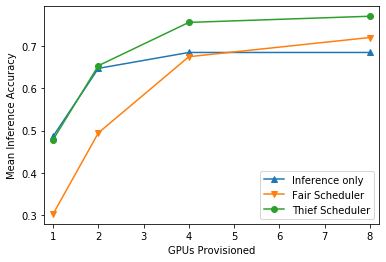

In [122]:
ax = mean_acc_data.plot(y=scheds, kind='line', style=styles,
                       label = ["Inference only", "Fair Scheduler", "Thief Scheduler"])#, yerr=std_acc_data)
ax.set_xlim([0.8, 8.2])
ax.set_ylabel('Mean Inference Accuracy')
ax.set_xlabel('GPUs Provisioned')

Text(0.5, 0, 'Video Stream')

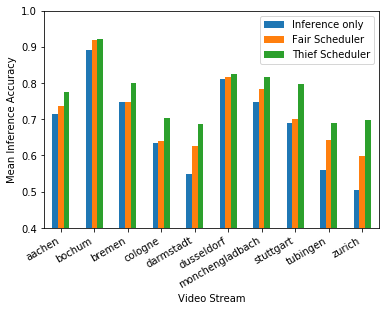

In [212]:
NUM_RES = 8
per_city_data = plot_data.query('res == {}'.format(NUM_RES))['overall_mean'].mean(level=['sched', 'city']).unstack(level=0)
per_city_data
ax = per_city_data.plot(y=scheds, kind='bar',
                       label = ["Inference only", "Fair Scheduler", "Thief Scheduler"])
ax.set_ylim([0.4,1])
ax.set_ylabel('Mean Inference Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_xlabel('Video Stream')

# Time Series Plot

In [243]:
NUM_RES = 4
city = 'zurich'
timeseries_data = plot_data.query('res == {}'.format(NUM_RES)).query('city == \'{}\''.format(city))

In [244]:
d = timeseries_data[tasks].mean(level=['sched']).transpose()
d = d[scheds]

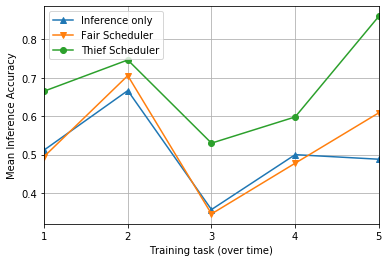

In [247]:
ax=d.plot(y=scheds, style = styles, label = ["Inference only", "Fair Scheduler", "Thief Scheduler"])
ax.set_ylabel('Mean Inference Accuracy')
ax.set_xlabel('Training task (over time)')
ax.set_xticks(range(0,5))
ax.set_xticklabels(range(1,6))
ax.grid(True)